<a href="https://colab.research.google.com/github/SingamSaiVaraPrasad/my_projects/blob/main/DQN_frozenLake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

policy_dqn is: 
00,R,[+0.07 +0.05 +0.08 +0.06] 01,R,[+0.07 -0.01 +0.08 +0.06] 02,D,[+0.02 +0.02 +0.02 +0.02] 03,L,[+0.01 -0.00 +0.01 +0.01] 
04,R,[+0.06 +0.05 +0.09 +0.06] 05,R,[+0.23 -0.08 +0.39 +0.19] 06,D,[+0.01 +0.07 +0.06 +0.05] 07,R,[-0.16 +0.17 +0.17 -0.02] 
08,R,[+0.04 -0.01 +0.15 +0.06] 09,R,[+0.12 +0.11 +0.17 +0.04] 10,D,[+0.12 +0.12 +0.09 +0.11] 11,R,[+0.08 +0.09 +0.26 -0.08] 
12,D,[-0.14 +0.18 +0.08 +0.01] 13,R,[-0.06 +0.08 +0.18 +0.03] 14,R,[-0.02 +0.13 +0.46 +0.22] 15,U,[-0.15 -0.22 +0.18 +0.38] 


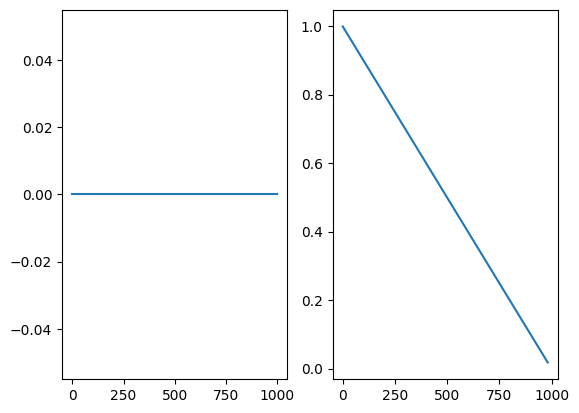

In [68]:
!pip install gymnasium

import gymnasium as gym
import torch as torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn.functional as F
from collections import deque

class deepQnet(nn.Module):
                                             # when ever we define a class we need to have __init__
  def __init__(self,nInput,nHidden,nOutput):
    super().__init__()
    self.fc1=nn.Linear(nInput,nHidden)
    self.outfcn=nn.Linear(nHidden,nOutput)
  def forward(self,x_inp):                #this calculates output for an input through the network
    self.x_inp=F.relu(self.fc1(x_inp))
    x_inp=self.outfcn(x_inp)
    return x_inp
class replay_buffer_memory():
  def __init__(self,maxlen):
    self.memory=deque([],maxlen=maxlen)   # double ended queue stores the states rewards nextstates actions
  def addData(self,transition):
    self.memory.append(transition)
  def sample(self,sampSize):
    return random.sample(self.memory,sampSize)     # gives random batch of given size
  def __len__(self):
    return len(self.memory)

class lake():
  learning_rate=0.001              # alpha for the equation of Temporal difference
  disc_factor=0.9                   #gamma
  replay_mem=1000                   # memory of replay buffer
  batch_sz=32                       # buffer size each time
  sync_rate=10                      # time steps after which sync of target and policy networks sync
  lossfcn=nn.MSELoss()
  optimizer=None
  ACTIONS=['L','D','R','U']
  def train(self,episodes,render=False,is_slippery=False):
    env=gym.make('FrozenLake-v1',map_name="4x4",is_slippery=is_slippery,render_mode='human' if render else None)
    num_states=env.observation_space.n
    num_actions=env.action_space.n

    epsilon=1 #100% random actions
    memory=replay_buffer_memory(self.replay_mem) #creating an object of memory class for lake object

    # create a target and policy network as objects of DeepQnet class
    policy_net=deepQnet(nInput=num_states,nHidden=num_states,nOutput=num_actions)
    target_net=deepQnet(nInput=num_states,nHidden=num_states,nOutput=num_actions)
    target_net.load_state_dict(policy_net.state_dict()) ##make target and policy networks same

    self.optimizer=torch.optim.Adam(policy_net.parameters(),lr=self.learning_rate)
    rewards=np.zeros(episodes) # rewards are stored in episodes initialized to 0

    #epsilon decay has to be tracked
    epsi=[]
    step_cnt=0;
    for i in range(episodes):
      state=env.reset()[0]
      terminated=False
      truncated=False
      while((not terminated) and (not truncated) ):
        if random.random()<epsilon:
          action=env.action_space.sample()
        else:
          with torch.no_grad():
            action=policy_net(self.state_to_dqn(state,num_states)).argmax().item()  #gives current state and total states to DQN
        nxt_state,reward,terminated,truncated,_= env.step(action)
        memory.addData((state,action,nxt_state,reward,terminated))
        state=nxt_state
        step_cnt+=1
      if reward==1:
          rewards[i]=1
      if(len(memory)>self.batch_sz and np.sum(rewards)>0): # only if the batch size is met and rewards are received
          mini_batch=memory.sample(self.batch_sz)
          self.optim(mini_batch,policy_net,target_net) #a function
          epsilon=max(epsilon-1/episodes,0)
          epsi.append(epsilon)
          if step_cnt>self.sync_rate:
            target_net.load_state_dict(policy_net.state_dict())
            step_cnt=0
    env.close()
    torch.save(policy_net.state_dict(),"frozenLake_dict.pt")
    plt.figure(1)
    tot_sum=np.zeros(episodes)
    for i in range(episodes):
      tot_sum[i]=np.sum(tot_sum[max(0,i-100):i+1]) #recent 100 episodes cumulative sum is added
    plt.subplot(121)
    plt.plot(tot_sum)
    plt.subplot(122)
    plt.plot(epsi)
    plt.savefig("frozen_lake_graph.png")
  def optim(self,mini_batch,policy_net,target_net):
        num_states=policy_net.fc1.in_features
        current_q_list=[]
        targetQlist=[]
        for state,action,nxt_state,reward,terminated in mini_batch:
          if terminated:
            target=torch.FloatTensor([reward])
          else:
            with torch.no_grad():
                target=torch.FloatTensor(
                    reward+self.disc_factor*target_net(self.state_to_dqn(state,num_states)).max()
                    )
          current_q=policy_net(self.state_to_dqn(state,num_states))
          current_q_list.append(current_q)
          target_q=target_net(self.state_to_dqn(state,num_states))
          target_q[action]=target                        # for the current tupple, it has an action, for that action we are finding the bellman equation using above line
          targetQlist.append(target_q)   #then we put them into list after finding new target for current action
        loss=self.lossfcn(torch.stack(current_q_list),torch.stack(targetQlist))
        self.optimizer.zero_grad()                       #initially gradient of all weights are made zero other wise they accumulate
        loss.backward()                                  #calculates gradient and stores
        self.optimizer.step()                            #updates the weights
  def state_to_dqn(self,stt,num_stts):
        arr=torch.zeros(num_stts)
        arr[stt]=1
        return arr
  def test(self,numEpisodes,is_slippery=False):
      env=gym.make("FrozenLake-v1",map_name="4x4",is_slippery=is_slippery,render_mode='human')
      numState=env.observation_space.n
      numActions=env.action_space.n
      policy_dqn=deepQnet(numState,numState,numActions)
      policy_dqn.load_state_dict(torch.load("frozenLake_dict.pt"))
      policy_dqn.eval()
      print("policy_dqn is: ")
      self.print_dqn(policy_dqn)
      for this_epsd in range(numEpisodes):
        state=env.reset()[0]
        terminated=False
        truncated=False
        while not terminated and not truncated:
          with torch.no_grad():
            action=policy_dqn(self.state_to_dqn(state,numState)).argmax().item()
          state,reward,terminated,truncated,_=env.step(action)
      env.close()
  def print_dqn(self,dqn):
      numStates=dqn.fc1.in_features
      for s in range(numStates):
            q_values = ''
            for q in dqn(self.state_to_dqn(s, numStates)).tolist():
                q_values += "{:+.2f}".format(q)+' '  # Concatenate q values, format to 2 decimals
            q_values=q_values.rstrip()              # Remove space at the end

            # Map the best action to L D R U
            best_action = self.ACTIONS[dqn(self.state_to_dqn(s, numStates)).argmax()]

            # Print policy in the format of: state, action, q values
            # The printed layout matches the FrozenLake map.
            print(f'{s:02},{best_action},[{q_values}]', end=' ')
            if (s+1)%4==0:
                print() # Print a newline every 4 states
if __name__=='__main__':
      frozen_l=lake()
      is_slip=False
      frozen_l.train(1000,is_slippery=is_slip)
      frozen_l.test(10,is_slippery=is_slip)



